In [5]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [24]:
#Reading in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [25]:
#Reading in training data
train_data_df = pd.read_csv("train.csv")
train_data_raw.tail(6)

,id,qid1,qid2,question1,question2,is_duplicate
404284,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [47]:
person = input('Enter your name: ')
print('Hello', person)

Enter your name: Ashwin
Hello Ashwin


# Look at some statistics of training data

In [52]:
print ("Number of training data",len(train_data_raw) )
print ("Ratio of duplicate question pairs: ", round(train_data_raw['is_duplicate'].mean()*100,2)) 
qids = pd.Series(train_data_raw['qid1'].tolist() + train_data_raw['qid2'].tolist())
print ("Total number of questions: ", len(np.unique(qids)))
print ("Number of questions appearing multiple times: ", np.sum(qids.value_counts()>1))

Number of training data 404290
Ratio of duplicate question pairs:  36.92
Total number of questions:  537933
Number of questions appearing multiple times:  111780


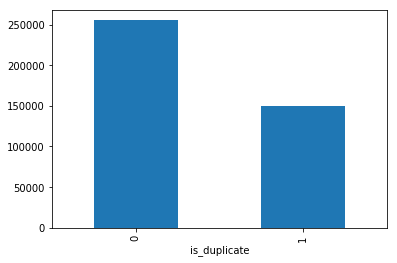

In [53]:
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()

In [59]:
#Reading in test data and look at the first 5 rows
test_data_raw = pd.read_csv("test.csv")
print ("Number of testing data:", len(test_data_raw))
test_data_raw.head(6)

Number of testing data: 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...


(-0.5, 1279.5, 979.5, -0.5)

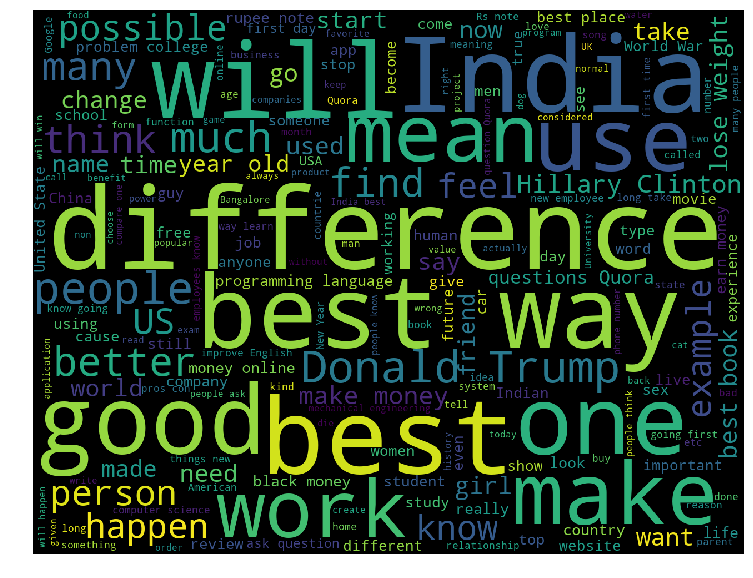

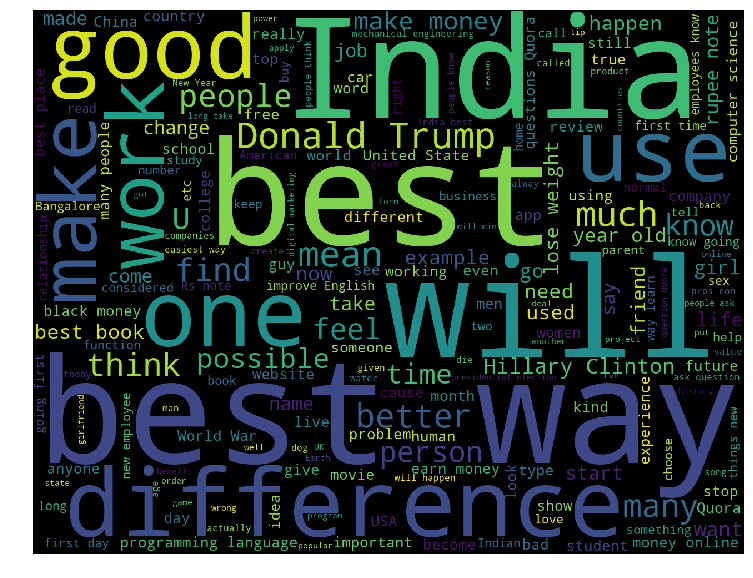

In [60]:
#Checking out the most common words in word cloud graph from training data.
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

(-0.5, 1279.5, 979.5, -0.5)

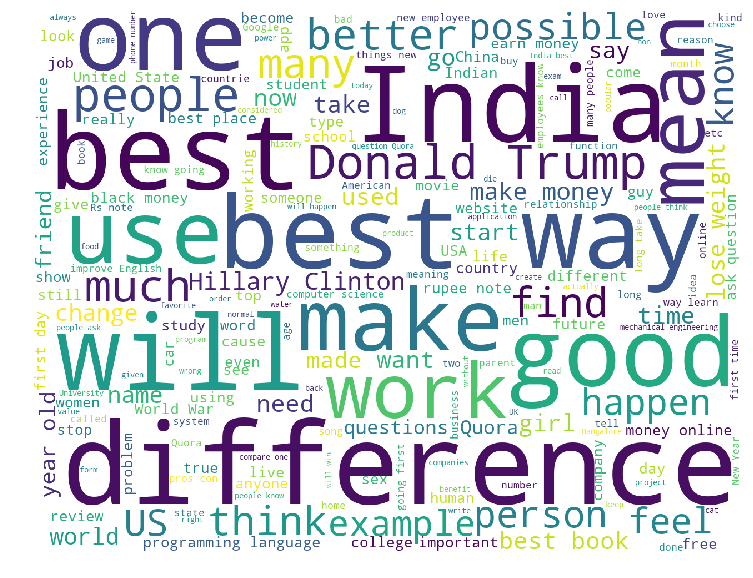

In [63]:
cloud1 = WordCloud(width=1280, 
                   height=980,
                   background_color='white'
                   ).generate(" ".join(train_data_raw['question1'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')


(-0.5, 1279.5, 979.5, -0.5)

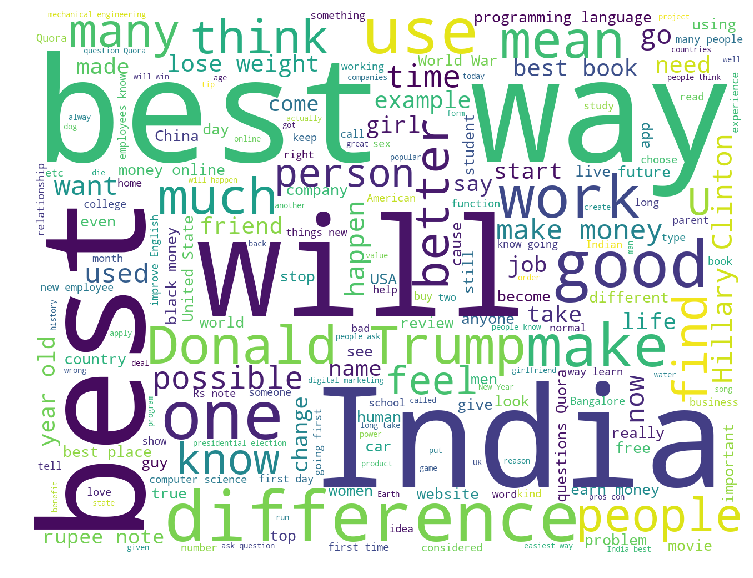

In [64]:
#Checking out the most common words in word cloud graph from training data.
cloud2 = WordCloud(width=1280, 
                   height=980,
                   background_color='white'
                  ).generate(" ".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

lets do some data processing


In [65]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [68]:
#Combine all questions into corpus for analysis similar to Term-frequency in TFIDF
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print ("Most common words: "), (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])


Most common words: 


(None,
 [('the', 2.623060902228028e-06),
  ('what', 3.164927538983995e-06),
  ('is', 3.651647440742891e-06),
  ('how', 4.463907079310237e-06),
  ('i', 4.5832664940302954e-06),
  ('a', 4.646127684881036e-06),
  ('to', 4.783155639101341e-06),
  ('in', 5.006909535158519e-06),
  ('of', 6.100834594172483e-06),
  ('do', 6.260956674179815e-06)])

In [69]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [70]:
#Construct features for training data: character length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66,57.0,14,12,0.434783,0.400611
1,51,88.0,8,13,0.200000,0.193056
2,73,59.0,14,10,0.166667,0.149204
3,50,65.0,11,9,0.000000,0.000000
4,76,39.0,13,7,0.100000,0.009949


In [71]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(train_data))
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [ ]:
#Process test data to have the same features as training data
test_data = pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
test_data.head()

# The relations between two questions

Text(0,0.5,'Probability')

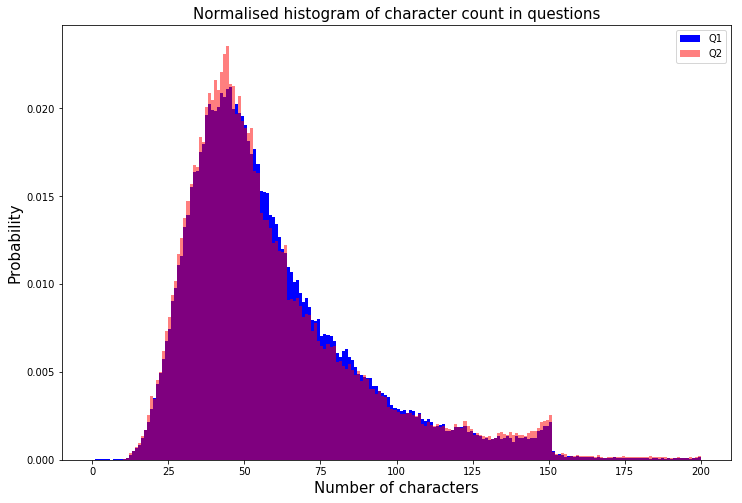

In [73]:
#Getting some visual on character count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)


This shows that most questions have about 40-50 characters in them.

Text(0,0.5,'Probability')

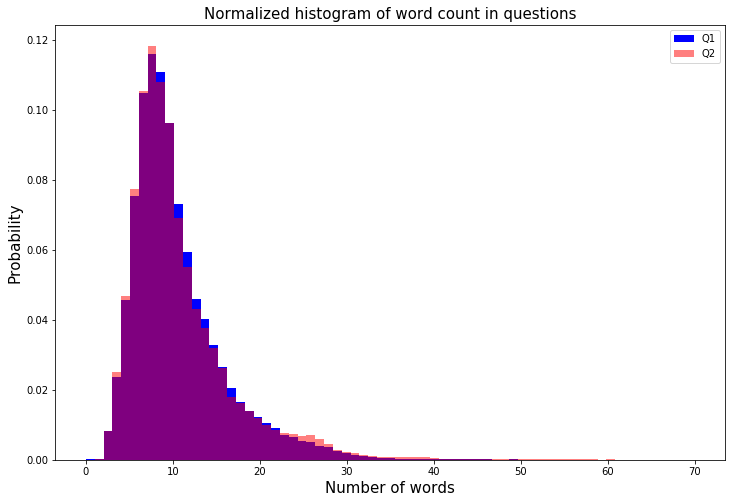

In [74]:
#Get some visual on word count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

This shows that most questions have about 10 words in them.

Text(0.5,0,'word_share_ratio')

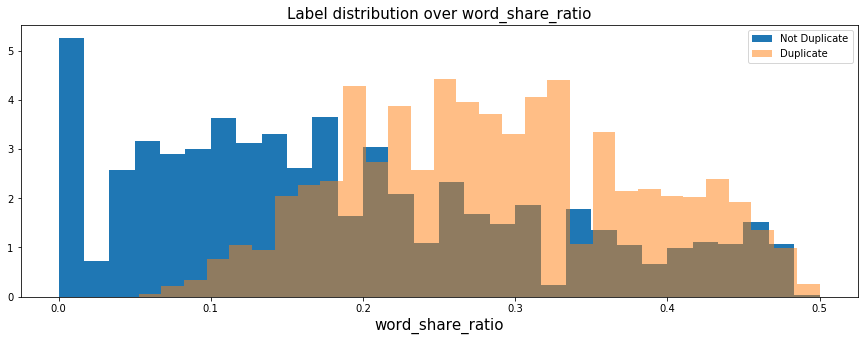

In [75]:
#Get some visual on word share
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

This shows that the word share ratio is higher for duplicate question pairs.

Text(0.5,0,'TFIDF_share')

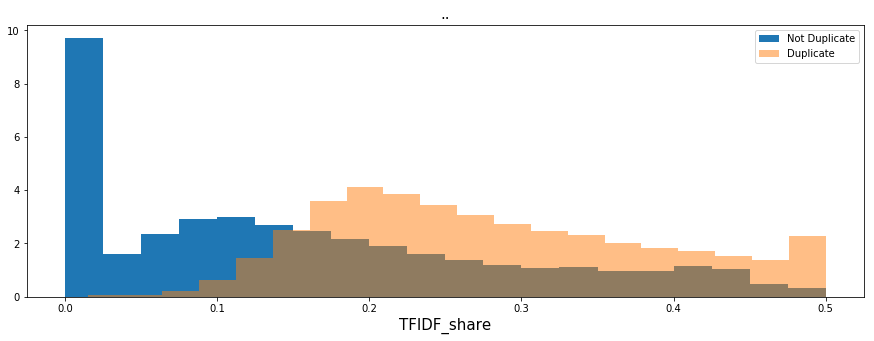

In [76]:
#Get some visual on TFIDF word share
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

# Now, normalizing all features for better machine learning accuracy.

In [78]:
#Normalized feature values
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').